In [1]:
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import json
from sqlalchemy import create_engine
import urllib
import zipfile
import rasterstats
import folium
from shapely.geometry import Point

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', 500)

Running API query

In [2]:
start_time = 'now-180days'
#end_time = '2022-06-22' #'now-180days'
min_magnitude = 4

#https://earthquake.usgs.gov/fdsnws/event/1/count?starttime=2014-01-01&endtime=2014-01-02

# Radius parameters
#latitude = 39.1458
#longitude = 34.1614
#max_radius_km = 1500

# Bounding Box parameters (set to Afghanistan)
minlatitude = 29.377065
maxlatitude = 38.490842
minlongitude = 60.471977
maxlongitude = 74.889561

#minlongitude = -179
#maxlongitude = 179
#minlatitude = -90
#maxlatitude = 90

In [3]:
#radius_query = f'\
#https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson\
#&starttime={start_time}\
#&minmagnitude={min_magnitude}\
#&latitude={latitude}\
#&longitude={longitude}\
#&maxradiuskm={max_radius_km}\
#&producttype=shakemap'

In [4]:
bbox_query = f'\
https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson\
&starttime={start_time}\
&minmagnitude={min_magnitude}\
&minlatitude={minlatitude}\
&maxlatitude={maxlatitude}\
&minlongitude={minlongitude}\
&maxlongitude={maxlongitude}'
#&producttype=shakemap'

#&endtime={end_time}\

In [5]:
# Run query and check response
url = requests.get(bbox_query)
featureCollection = url.json()

Unpacking JSON

In [6]:
# Restructure to get a list of features instead of a feature collection
features = featureCollection['features']

In [7]:
# Sort the features based on the 'time' property
features_sorted = sorted(features, key=lambda x: x['properties']['time'], reverse=True)

In [8]:
# Get the most recent feature
feature_newest = features_sorted[0]

In [9]:
# Open the details url in the feature (contains properties, epicenter and shakemap)
detail_url = feature_newest['properties']['detail']
url = requests.get(detail_url)

# Save to new variable
feature_newest_detail = url.json()

Extracting Epicenter

In [10]:
# Extracting epicenter coordinates
coordinates = feature_newest_detail['geometry']

In [11]:
# Extract the epicenter attributes
attributes = feature_newest_detail['properties']

In [12]:
### Convert time

# Convert UNIX timestamp to normal time
attributes['time'] = pd.to_datetime(attributes['time'], unit='ms')

# Convert to Kabul time
timezone = 'Asia/Kabul'
attributes['time'] = attributes['time'].tz_localize('UTC').tz_convert(timezone)

# Set time-zone column
attributes['tz'] = timezone

# Reformat time
attributes['time'] = attributes['time'].strftime('%Y-%m-%d %H:%M:%S')

In [13]:
# Create a pandas DataFrame
data = pd.DataFrame(attributes, index=[0])
data['geometry'] = Point(coordinates['coordinates'])

# Convert to a GeoDataFrame
epicenter = gpd.GeoDataFrame(data)
epicenter.rename(columns = {'geom':'buildings'}, inplace = True)

In [14]:
#  First define the true original crs
epicenter.crs = "EPSG:4326"

In [15]:
# Reproject to projected crs before calculating shakemap
epicenter = epicenter.to_crs('+proj=cea')

In [16]:
# Create shakemap as donut rings from epicenter

def create_donut_rings(center, radii):
    # create circles from radii
    circles = [center.buffer(radius) for radius in radii]
    
    # create donut rings by subtracting each inner circle from the outer circle
    donut_rings = [circles[i].difference(circles[i-1]) for i in range(1, len(circles))]
    
    # add the innermost circle
    donut_rings.insert(0, circles[0])
    
    # create a GeoDataFrame with the donut rings and their corresponding radii
    donut_rings_gdf = gpd.GeoDataFrame(geometry=donut_rings)
    donut_rings_gdf['distance'] = radii
    
    return donut_rings_gdf

# specify radii of circles: 10km, 20km, 30km, 40km, 50km
radii = [10000, 20000, 30000, 40000, 50000]

# create a GeoDataFrame of donut rings
donut_rings_gdf = create_donut_rings(epicenter.geometry[0], radii)

donut_rings_gdf.crs = "+proj=cea"

shakemap = donut_rings_gdf

<AxesSubplot:>

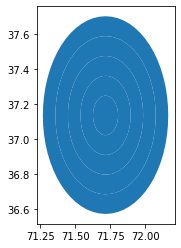

In [52]:
shakemap.plot()

In [17]:
#  # create a Folium map
#  m = folium.Map(location=[0, 0], zoom_start=2)

#  # add the GeoDataFrame to the Folium map
#  folium.GeoJson(epicenter).add_to(m)
#  folium.GeoJson(donut_rings_gdf).add_to(m)

#  # show the map
#  m.save('map_v09.html')

In [18]:
# Define projection
#repro_crs = '+proj=cea'

Extracting shakemap

In [19]:
# # Get the URLs for the ShakeMap files (many different data formats available)
# shakemap_files = feature_newest_detail['properties']['products']['shakemap']

In [20]:
# # Select the shape format
# shakemap_shape_url = shakemap_files[0]['contents']['download/shape.zip']['url']

In [21]:
# # Downloading the shakemap

# # Specify the URL of the file to download
# file_url = shakemap_shape_url

# # Specify the path to save the downloaded file
# save_path = r'D:\iMMAP\proj\ASDC\data\USGS\shp.zip'

# # Download the file
# urllib.request.urlretrieve(file_url, save_path)

# print('File downloaded successfully.')

In [22]:
# # Extract the zip
# with zipfile.ZipFile(r'D:\iMMAP\proj\ASDC\data\USGS\shp.zip', "r") as zip_ref:
#     # Extract the shapefile
#     zip_ref.extractall("temp_extracted_files")

# # Path to the extracted shapefile
# shapefile_path = "temp_extracted_files/" + 'mi.shp'

In [23]:
# # Read the shapefile as a GeoPandas DataFrame
# shakemap = gpd.read_file(shapefile_path)
# shakemap

In [24]:
# # Remove rows if PARAMVALUE = 1
# shakemap = shakemap[shakemap['PARAMVALUE'] != 1]
# shakemap

In [25]:
# Create list of columns to user for ordering
shakemap_columns = list(shakemap.columns)
epicenter_columns = list(epicenter.drop(columns='geometry').columns)
column_order = epicenter_columns + shakemap_columns

In [26]:
# Add a temporary column to both DataFrames with a constant value to create a Cartesian product merge
shakemap['_merge_key'] = 1
epicenter['_merge_key'] = 1

# Perform a merge on the temporary column
shakemap = pd.merge(shakemap, epicenter.drop(columns='geometry'), how='left', on='_merge_key')

# Remove the temporary column
shakemap = shakemap.drop(columns='_merge_key')

#shakemap = shakemap.reindex(columns=column_order)

In [27]:
# # Reorder columns
# shakemap = shakemap.reindex(columns=column_order)

Merging shakemap

In [28]:
# # Define the merge categories
# merge_categories = [(4, 5), (5, 6), (6, 7), (7, 8), (8, 9)] #(1, 2),(2, 3),(3, 4),

# # Create a new column to store the merged categories
# shakemap['MergeCategory'] = None

# # Iterate over the merge categories
# for category in merge_categories:
#     # Extract the minimum and maximum values of the category
#     min_value, max_value = category
    
#     # Select polygons within the current category
#     category_polygons = shakemap[(shakemap['PARAMVALUE'] >= min_value) & (shakemap['PARAMVALUE'] < max_value)]
    
#     # Assign the merge category to the selected polygons
#     shakemap.loc[category_polygons.index, 'MergeCategory'] = f'{min_value}-{max_value}'
    
# # Dissolve the polygons based on the merge category
# shakemap = shakemap.dissolve(by='MergeCategory')
# shakemap

In [29]:
# type(shakemap)

Calculating population count

In [30]:
# Get population raster
pop = r'D:\iMMAP\data\Afghanistan\afg_worldpop_2020_UNadj_unconstrained_projCEA_comp.tif'  #_projCEA

In [31]:
#import rasterio
#pop = rasterio.open(pop)
#pop.crs


In [32]:
#shakemap.crs

In [33]:
# Run zonal statistics
zonal = rasterstats.zonal_stats(shakemap, pop, stats = 'sum')

In [34]:
# Convert to pandas dataframe
df = pd.DataFrame(zonal)
df = df.rename(columns={'sum': 'pop'})

In [35]:
# Drop index column
shakemap = shakemap.reset_index(drop=True)

In [36]:
# Concatenate pop values and shakemap as a pandas dataframe
df_concat = pd.concat([df, shakemap], axis=1)

In [37]:
# Turn pandas dataframe back into a geodataframe
shakemap = gpd.GeoDataFrame(df_concat, geometry=df_concat.geometry) #wkb_geometry

In [38]:
# Fill all NAN values as 0
#shakemap['pop'].fillna(0, inplace=True)

Calculating building count

In [39]:
# (OBS: Change to live database)

# Load database configuration from file
with open(r'D:\iMMAP\code\db_config\hsdc_local_db_config.json', 'r') as f:
    config = json.load(f)

# Create database URL with credentials
db_url = f"postgresql://{config['username']}:{config['password']}@{config['host']}:{config['port']}/{config['database']}"

# Connect to the database
con = create_engine(db_url)

In [40]:
# OBS: change to correct building dataset

# Load buildings from database
buildings = gpd.GeoDataFrame.from_postgis('SELECT * from point_sample', con, geom_col='geometry').to_crs('+proj=cea')   #afg_buildings_microsoft_centroids

In [41]:
# Joining the polygon attributes to each point
# Creates a point layer of all buildings with the attributes copied from the interesecting polygon uniquely for each point
joined_df = gpd.sjoin(
    buildings,
    shakemap,
    how='inner',
    predicate='intersects')

In [42]:
# Count number of buildings within admin polygons (i.e. group by adm code)
build_count = joined_df.groupby(
    ['distance'],
    as_index=False,
)['geometry'].count() # column is arbitrary

# Change column name to build_count
build_count.rename(columns = {'geometry': 'buildings'}, inplace = True)

In [43]:
# Merge build count back on to shakemap
shakemap = shakemap.merge(
    build_count, 
    on=['distance'], 
    how='left')

Calculating Area

In [44]:
#shakemap['km2'] = shakemap['geometry'].area.div(1000000)

In [45]:
# Get area from a reprojected version of shakemap
#shakemap_repro = shakemap.to_crs('+proj=cea')
shakemap['km2'] = shakemap['geometry'].area.div(1000000)

Cleaning tables

In [46]:
columns_shakemap = [
 'distance',
 'pop',
 'buildings',
 'km2',
 'geometry']

columns_epicenter = [
'title',
 'place',
 'mag',
 'time',
 'type',
 'cdi',
 'mmi',
 'alert',
 'geometry']

In [47]:
shakemap = shakemap[columns_shakemap]
#shakemap = shakemap.rename(columns={'PARAMVALUE': 'mag_zone'})

epicenter = epicenter[columns_epicenter]

Saving outputs to database

In [48]:
# Connecting to database

# Load database configuration from file
with open(r'D:\iMMAP\code\db_config\hsdc_local_db_config.json', 'r') as f:
    config = json.load(f)

# Create database URL with credentials
db_url = f"postgresql://{config['username']}:{config['password']}@{config['host']}:{config['port']}/{config['database']}"

# Connect to the database
con = create_engine(db_url)

In [49]:
# Reproject from +proj=cea to 4326 before saving
epicenter = epicenter.to_crs('EPSG:4326')
shakemap = shakemap.to_crs('EPSG:4326')

In [50]:
# Saving epicenter to database
epicenter.to_postgis('usgs-epicenter-test_v11', con, if_exists='replace')

In [51]:
# Saving shakemap to database
shakemap.to_postgis('usgs-shakemap-test_v11', con, if_exists='replace')